In [1]:
from utils import *
print_version()

python:      3.10.11
sklearn:     1.2.2
tensorflow:  2.13.0-rc0
keras:       2.13.1rc0
numpy:       1.24.3
pandas:      1.5.3


# 特徴量名の読み込み

In [2]:
with open("../dataset/kddcup.names") as fp:
    # 一行目は不要なので無視
    _ = fp.readline()
    # `:`より手前がラベルなので，その部分を抽出してリストに追加
    names = [line.split(':')[0] for line in fp]
print(f"特徴量の数：{len(names)}")
print(f"各特徴量の名前：{', '.join(names)}")

特徴量の数：41
各特徴量の名前：duration, protocol_type, service, flag, src_bytes, dst_bytes, land, wrong_fragment, urgent, hot, num_failed_logins, logged_in, num_compromised, root_shell, su_attempted, num_root, num_file_creations, num_shells, num_access_files, num_outbound_cmds, is_host_login, is_guest_login, count, srv_count, serror_rate, srv_serror_rate, rerror_rate, srv_rerror_rate, same_srv_rate, diff_srv_rate, srv_diff_host_rate, dst_host_count, dst_host_srv_count, dst_host_same_srv_rate, dst_host_diff_srv_rate, dst_host_same_src_port_rate, dst_host_srv_diff_host_rate, dst_host_serror_rate, dst_host_srv_serror_rate, dst_host_rerror_rate, dst_host_srv_rerror_rate


In [3]:
#　正解ラベルを追加
names.append("true_label")
data = pd.read_csv("../dataset/kddcup.data", names=names, index_col=False)
true_label = data.pop('true_label')

# データの把握

In [4]:
data.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

`protocol_type`, `service`, `flag` がカテゴリー特徴量のため，ワンホットエンコーディングする必要がある．

In [5]:
true_label_counts = true_label.value_counts()
true_label_counts

smurf.              2807886
neptune.            1072017
normal.              972781
satan.                15892
ipsweep.              12481
portsweep.            10413
nmap.                  2316
back.                  2203
warezclient.           1020
teardrop.               979
pod.                    264
guess_passwd.            53
buffer_overflow.         30
land.                    21
warezmaster.             20
imap.                    12
rootkit.                 10
loadmodule.               9
ftp_write.                8
multihop.                 7
phf.                      4
perl.                     3
spy.                      2
Name: true_label, dtype: int64

- 正解ラベルに`.`がついている．
　-> 外す．
- 今回は，`normal`ラベルを正常値，それ以外を`anormal`とラベル付し，異常値とみなす．
- それらを，`normal` -> `0`, `anormal` -> `1`として，学習させる．

In [6]:
# 正解ラベルのピリオドを外す．
true_label = true_label.map(lambda x: x.replace('.', ''))
true_label_counts = true_label.value_counts()

### 攻撃の種類は，大まかに４種類(`Dos`, `U2R`, `R2L`, `Probe`)
### 後の学習プログラムのために，予め各クラスを定義しておく，
### class -> `Dos`, `U2R`, `R2L`, `Probe`
### label -> `duration`, `protocol_type`, `service`, `flag`, `src_bytes`, `dst_bytes`, `land`, `wrong_fragment`, `urgent`, `hot`, `num_failed_logins`, `logged_in`, `num_compromised`, `root_shell`, `su_attempted`, `num_root`, `num_file_creations`, `num_shells`, `num_access_files`, `num_outbound_cmds`, `is_host_login`, `is_guest_login`, `count`, `srv_count`, `serror_rate`, `srv_serror_rate`, `rerror_rate`, `srv_rerror_rate`, `same_srv_rate`, `diff_srv_rate`, `srv_diff_host_rate`, `dst_host_count`, `dst_host_srv_count`, `dst_host_same_srv_rate`, `dst_host_diff_srv_rate`, `dst_host_same_src_port_rate`, `dst_host_srv_diff_host_rate`, `dst_host_serror_rate`, `dst_host_srv_serror_rate`, `dst_host_rerror_rate`

In [7]:
# attack_class_labels -> key: class, value: list[label]
attack_class_labels = {
    'normal': ['normal'],
    'dos': ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop'],
    'u2r': ['buffer_overflow', 'loadmodule', 'perl', 'rootkit'],
    'r2l': ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'phf', 'spy', 'warezclient', 'warezmaster'],
    'probe': ['ipsweep', 'nmap', 'portsweep', 'satan']
}
# attack_class_label -> key: label, value: class
attack_label_class = {}
for c, labels in attack_class_labels.items():
    for label in labels:
        attack_label_class[label] = c
attack_label_class

{'normal': 'normal',
 'back': 'dos',
 'land': 'dos',
 'neptune': 'dos',
 'pod': 'dos',
 'smurf': 'dos',
 'teardrop': 'dos',
 'buffer_overflow': 'u2r',
 'loadmodule': 'u2r',
 'perl': 'u2r',
 'rootkit': 'u2r',
 'ftp_write': 'r2l',
 'guess_passwd': 'r2l',
 'imap': 'r2l',
 'multihop': 'r2l',
 'phf': 'r2l',
 'spy': 'r2l',
 'warezclient': 'r2l',
 'warezmaster': 'r2l',
 'ipsweep': 'probe',
 'nmap': 'probe',
 'portsweep': 'probe',
 'satan': 'probe'}

In [8]:
true_labels = pd.DataFrame({
    'class': [attack_label_class[label] for label in true_label],
    'name': true_label,
    'label': [int(t_or_f) for t_or_f in true_label != 'normal']
})
true_labels

,class,name,label
0,normal,normal,0
1,normal,normal,0
2,normal,normal,0
3,normal,normal,0
4,normal,normal,0
...,...,...,...
4898426,normal,normal,0
4898427,normal,normal,0
4898428,normal,normal,0
4898429,normal,normal,0


In [9]:
print(f"データの総数：{len(data)}")
# 各クラスとそのクラスに属するラベルのデータ数
for c, labels in attack_class_labels.items():
    print(f"{c}: {len(true_label[true_labels['class'] == c])}")
    for l in labels:
        print(f"     {l}: {len(true_label[true_labels['name'] == l])}")

データの総数：4898431
normal: 972781
     normal: 972781
dos: 3883370
     back: 2203
     land: 21
     neptune: 1072017
     pod: 264
     smurf: 2807886
     teardrop: 979
u2r: 52
     buffer_overflow: 30
     loadmodule: 9
     perl: 3
     rootkit: 10
r2l: 1126
     ftp_write: 8
     guess_passwd: 53
     imap: 12
     multihop: 7
     phf: 4
     spy: 2
     warezclient: 1020
     warezmaster: 20
probe: 41102
     ipsweep: 12481
     nmap: 2316
     portsweep: 10413
     satan: 15892


In [10]:
print(f"正常ラベル：{len(true_label[true_labels['label'] == 0])}")
print(f"異常ラベル：{len(true_label[true_labels['label'] == 1])}")

正常ラベル：972781
異常ラベル：3925650


## 教師あり学習
- 学習データ：検証データ = 2 : 1
- k分割交差検証を用いる．（k=5）
- 学習にはlightGBMの勾配ブースティング決定木(Gradient Boosting Decision Tree，GBDT)を使う．
- random_state=2018
- 評価指標は，クロスエントロピー（log loss）を用いる．

In [11]:
# データの定義
data_x = data.copy()
data_y = true_labels['label'].copy()

In [12]:
# ワンホットエンコーディング　-> drop
data_x = data_x.drop(columns=['protocol_type', 'service', 'flag'], axis=1)

In [13]:
# 標準化
from sklearn.preprocessing import StandardScaler
data_x = pd.DataFrame(StandardScaler().fit_transform(data_x))

In [14]:
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, stratify=data_y, test_size=0.33, random_state=2018)

In [15]:
print(f"学習・正常ラベル：{np.sum(y_train == 0)}，学習・不正ラベル：{np.sum(y_train   == 1)}")
print(f"検証・正常ラベル：{np.sum(y_test == 0)}，検証・不正ラベル：{np.sum(y_test == 1)}")

学習・正常ラベル：651763，学習・不正ラベル：2630185
検証・正常ラベル：321018，検証・不正ラベル：1295465


In [16]:
# k-fold instance
#　`StratifiedKFold`は，，y_trainのラベル分布が近くなるように分割する．
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2018)
predictions_based_on_k_folds = pd.DataFrame(
    data=[], index=y_train.index, columns=['prediction']
)
# 学習
training_scores = [] # 学習率
validation_scores = [] # 検証スコア

# x_trainの値の分布を考慮せずに分割して欲しいため，0埋めした配列を`split()`の引数にいれ，そのランダムなインデックスのリストを取得する．
for train_idx, validation_idx in k_fold.split(np.zeros(len(x_train)), y_train.ravel()):
    x_train_fold, x_validation_fold = x_train.iloc[train_idx, :], x_train.iloc[validation_idx, :] # 2次元配列
    y_train_fold, y_validation_fold = y_train.iloc[train_idx], y_train.iloc[validation_idx] # １次元配列

    lgb_train = lgb.Dataset(x_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(x_validation_fold, y_validation_fold, reference=lgb_train)
    lgb_params = {
    'task': 'train',
    #    application = 'binary',
    'num_class': 1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq': 50,
    'is_training_metric': False,
    'max_depth': 4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    # 'num_iterations': 200,
    # これを指定しないと`No further splits with positive gain, best gain: -inf`というWarningが表示される
    'verbose': -1,
    'num_threads': 16,
    }
    gbm = lgb.train(lgb_params, lgb_train,
                    num_boost_round=2000,
                    valid_sets=lgb_eval,
                    callbacks=[lgb.early_stopping(200)]
                    )

    y_train_predict = gbm.predict(x_train_fold, num_iteration=gbm.best_iteration)
    training_score = log_loss(y_train_fold, y_train_predict)

    y_validation_predict = gbm.predict(x_validation_fold, num_iteration=gbm.best_iteration)
    predictions_based_on_k_folds.loc[x_validation_fold.index, 'prediction'] = y_validation_predict
    validation_score = log_loss(y_validation_fold, y_validation_predict)


    # print(f"training log loss:  {training_score}")
    # print(f"validation log loss: {validation_score}")
    training_scores.append(training_score)
    validation_scores.append(validation_score)

Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's binary_logloss: 0.000310429
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's binary_logloss: 0.000300951
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's binary_logloss: 0.000296924
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's binary_logloss: 0.000296045
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's binary_logloss: 0.000327315


In [17]:
validation_scores

[0.0003104290792162553,
 0.00030095085156625444,
 0.00029692422770067603,
 0.00029604548018600965,
 0.0003273152955602906]

In [18]:
log_loss_light_gbm_gradient_boosting = log_loss(y_train, predictions_based_on_k_folds.loc[:, 'prediction'])
print(f'Light GBM Gradient Boosting Log loss: {log_loss_light_gbm_gradient_boosting}')

Light GBM Gradient Boosting Log loss: 0.0003063329835872225


In [19]:
# Evaluate on Test Set
predictions = pd.Series(data=gbm.predict(x_test,
                                         num_iteration=gbm.best_iteration), index=x_test.index)

[1.99999997e+00 9.99999969e-01 9.99999958e-01 ... 5.71741272e-07
 5.69512381e-07 1.25756955e-07]


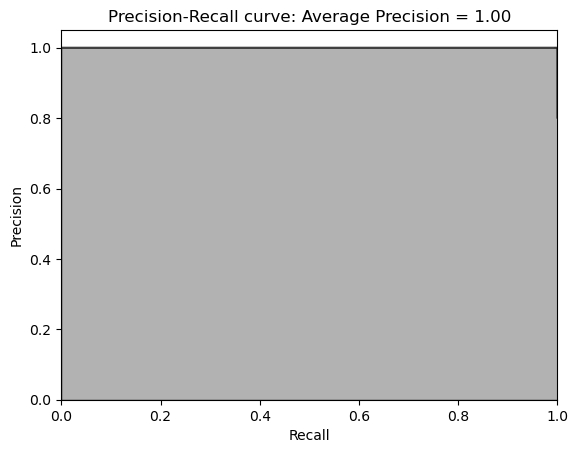

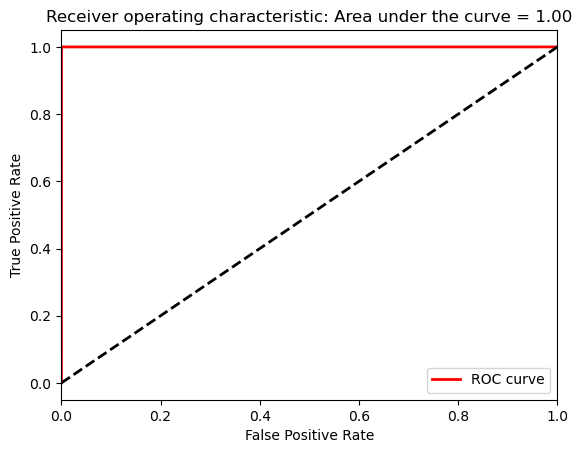

,true_label,anomaly_score
2828660,1,0.999999
4735908,1,0.999996
2100416,1,0.999999
1274026,1,0.999999
2213651,1,0.999999
...,...,...
3671619,1,0.999999
2682103,1,0.999999
3010182,1,0.999999
1495098,1,0.999999


In [20]:
preds, average_precision = plot_results(y_test, predictions, True)
preds[preds['true_label'] == 1]

[1.99999997e+00 9.99999969e-01 9.99999958e-01 ... 5.71741272e-07
 5.69512381e-07 1.25756955e-07]


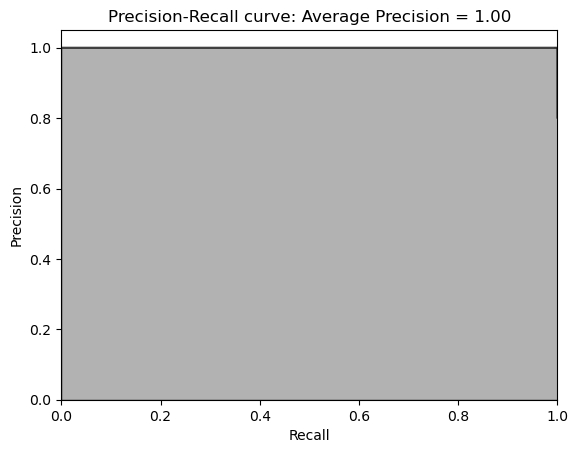

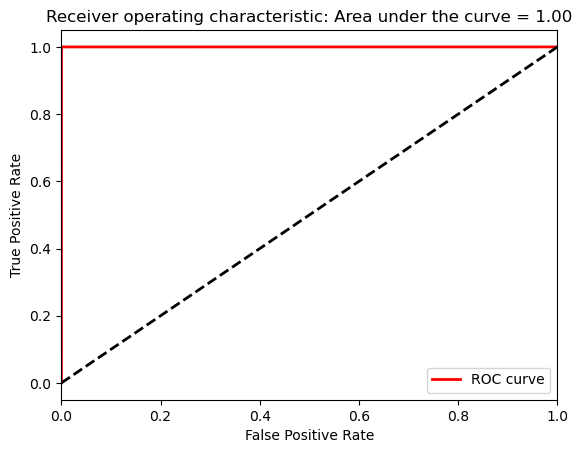

Precision at 75% recall 1.0


,true_label,anomaly_score
1265780,1,1.000000e+00
1265778,1,1.000000e+00
1265779,1,1.000000e+00
1265783,1,1.000000e+00
1265774,1,9.999999e-01
...,...,...
240790,0,5.281558e-07
155198,0,5.192964e-07
155194,0,4.780260e-07
833269,0,4.488229e-07


In [21]:
preds, average_precision = plot_results(y_test, predictions, True)
# Calculate precision at 75% recall
def precision_analysis(df: pd.DataFrame, column, threshold: float):
    """
    あるレベルの再現率(Recall)に対する適合率(Precision)を求める．
    再現率 = 真陽性 / (真陽性 + 偽陰性)
    適合率 = 真陽性　/ (真陽性 + 偽陽性)
    不正ラベルのうち，実際に検出できた不正の割合（再現率）が
    :param df:
    :param column:
    :param threshold:
    :return:
    Example:
        threshold = 0.4の場合，40％の再現率を達成した際の適合率
    """
    df.sort_values(by=column, ascending=False, inplace=True)
    threshold_value = threshold * df['true_label'].sum()  # 不正ラベルの個数
    i = 0
    j = 0
    while i <= threshold_value:
        if df.iloc[j]["true_label"] == 1:
            i += 1
        j += 1
    return df, i / j
preds, precision = precision_analysis(preds, "anomaly_score", 0.75)
print(f'Precision at 75% recall {round(precision, 4)}')
preds

## 教師なし学習
- 未完備オートエンコーダで，正常なラベルデータのみを用いて学習する．
- 入力は，１１８次元
- 隠れ層は，90 -> 60 -> 90 -> 118　とする．
- 活性化関数は，ReLU
- 最適化器は．adam
- 誤差関数は，平均二乗誤差(mean_squared_error)

In [22]:
model = keras.Sequential([
    Dense(units=30, activation='relu', input_dim=38),
    Dense(units=20, activation='relu'),
    Dense(units=30, activation='relu'),
    Dense(units=38, activation='relu'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                1170      
                                                                 
 dense_1 (Dense)             (None, 20)                620       
                                                                 
 dense_2 (Dense)             (None, 30)                630       
                                                                 
 dense_3 (Dense)             (None, 38)                1178      
                                                                 
Total params: 3598 (14.05 KB)
Trainable params: 3598 (14.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [24]:
# AutoEncoder用に，正常ラベルのみのDataFrameを定義
x_train_ae = x_train[y_train == 0]
y_train_ae = y_train[y_train == 0]
model.fit(x=x_train_ae, y=x_train_ae, epochs=5, batch_size=32, shuffle=True, validation_split=0.20)

Epoch 1/5
16295/16295 [==============================] - 9s 539us/step - loss: 1.4315 - accuracy: 0.8696 - val_loss: 0.9510 - val_accuracy: 0.8798
Epoch 2/5
16295/16295 [==============================] - 9s 536us/step - loss: 1.3231 - accuracy: 0.8783 - val_loss: 0.9714 - val_accuracy: 0.8791
Epoch 3/5
16295/16295 [==============================] - 9s 545us/step - loss: 1.3305 - accuracy: 0.8784 - val_loss: 0.9784 - val_accuracy: 0.8806
Epoch 4/5
16295/16295 [==============================] - 8s 517us/step - loss: 1.2112 - accuracy: 0.8786 - val_loss: 0.9579 - val_accuracy: 0.8808
Epoch 5/5
16295/16295 [==============================] - 9s 534us/step - loss: 1.2088 - accuracy: 0.8785 - val_loss: 0.9694 - val_accuracy: 0.8789


In [25]:
# 検証データの特徴量を再現したデータ
predicted_x_test = model.predict(x_test)

50516/50516 [==============================] - 15s 292us/step


In [26]:
# anomaly_score関数を改名したもの
def reconstruction_errors(original_df: pd.DataFrame, reconstructed_df: pd.DataFrame) -> np.ndarray:
    """
    元の特徴量行列と，新たに再構成された特徴量行列の間の再構成誤差を計算する．
    各特徴量ごとの再構成前後の誤差を二乗し，全ての特徴量を足し合わせる．正規化して0〜1に納める．
    0に近いほど正常，１に近いほど異常
    :param original_df: 元の特徴量の行列
    :param reconstructed_df: 再構成された特徴量の行列
    :param reversed:
    :return:
    """
    loss: np.ndarray = np.sum((np.array(original_df) - np.array(reconstructed_df)) ** 2, axis=1)
    loss: pd.Series = pd.Series(loss, index=original_df.index)
    loss: np.ndarray = (loss - np.min(loss)) / (np.max(loss) - np.min(loss))
    return loss

[2.00000000e+00 1.00000000e+00 6.81637327e-01 ... 3.65796489e-08
 3.24055165e-09 0.00000000e+00]


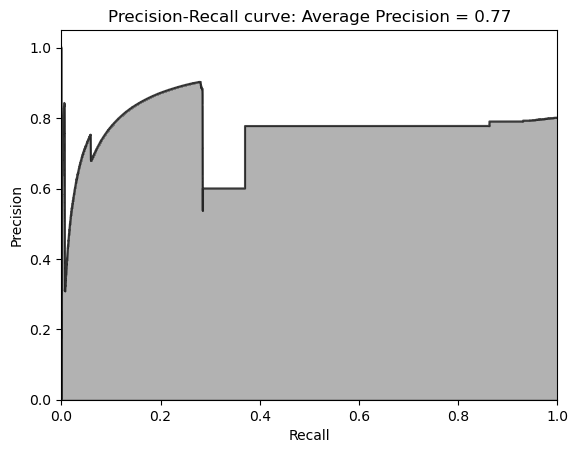

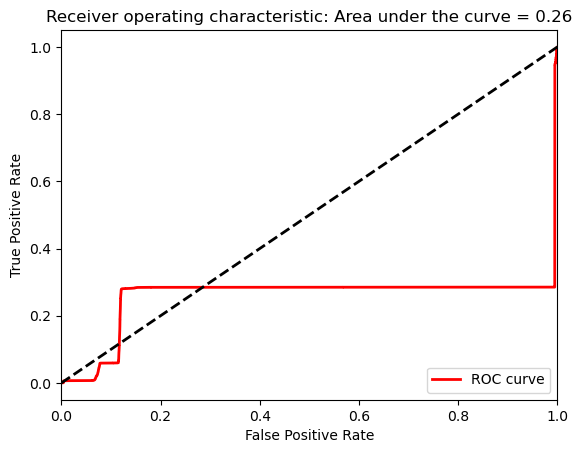

Precision at 75% recall 0.7527


In [27]:
errors = reconstruction_errors(x_test, predicted_x_test)
preds, _ = plot_results(y_test, errors, True)
_, precision = precision_analysis(preds, "anomaly_score", 0.75)
print(f'Precision at 75% recall {round(precision, 4)}')

In [28]:
errors[errors > 0.1]

3666530    1.000000
4469161    0.681953
421138     0.681637
dtype: float64

In [29]:
model_2 = keras.Sequential([
    Dense(units=20, activation='linear', input_dim=38),
    Dense(units=10, activation='linear'),
    Dense(units=38, activation='linear'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                1170      
                                                                 
 dense_1 (Dense)             (None, 20)                620       
                                                                 
 dense_2 (Dense)             (None, 30)                630       
                                                                 
 dense_3 (Dense)             (None, 38)                1178      
                                                                 
Total params: 3598 (14.05 KB)
Trainable params: 3598 (14.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/5
16295/16295 [==============================] - 8s 462us/step - loss: 0.9982 - accuracy: 0.7982 - val_loss: 0.4076 - val_accuracy: 0.7924
Epoch 2/5
16295/16295 [==============================] - 7s 448us/step - loss: 0.6793 - accuracy: 0.7816 - val_loss: 0.4067 - val_accuracy: 0.7693
Epoch 3/5
16295/16295 [==============================] - 8s 464us/step - loss: 0.6368 - accuracy: 0.7730 - val_loss: 0.4307 - val_accuracy: 0.7692
Epoch 4/5
16295/16295 [==============================] - 8s 491us/step - loss: 0.6443 - accuracy: 0.7787 - val_loss: 0.3953 - val_accuracy: 0.7705
Epoch 5/5
50516/50516 [==============================] - 12s 235us/step
[2.00000000e+00 1.00000000e+00 7.25083708e-01 ... 2.14891593e-08
 2.14855100e-08 0.00000000e+00]


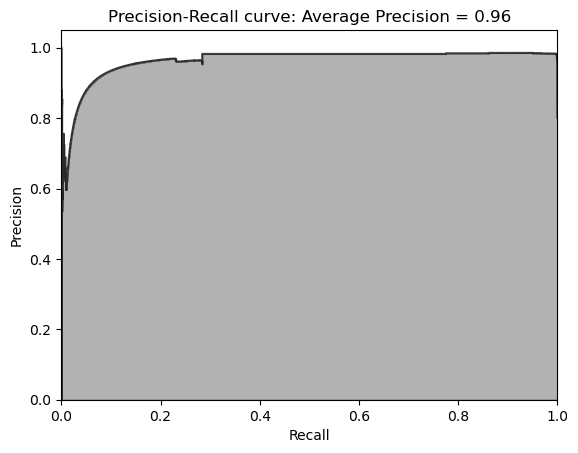

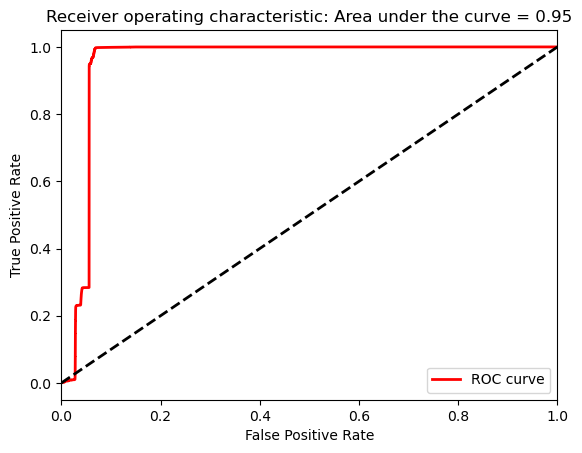

In [30]:
model_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model_2.fit(x=x_train_ae, y=x_train_ae, epochs=5, batch_size=32, shuffle=True, validation_split=0.20)
predicted_x_test = model_2.predict(x_test)
errors = reconstruction_errors(x_test, predicted_x_test)
preds, _ = plot_results(y_test, errors, True)

In [31]:
len(x_train), len(x_train_ae), len(x_test)

(3281948, 651763, 1616483)

In [32]:
predicted_x_test

array([[-1.7820022e-01, -3.1146079e-03,  2.3040310e-03, ...,
        -4.6588537e-01,  6.8591237e-03, -6.7303032e-03],
       [-4.9314407e-01, -2.4242515e-03,  4.9828603e-03, ...,
        -4.6484125e-01, -4.6213707e-01, -4.4713253e-01],
       [-3.6847934e-01, -6.2285559e-03, -5.6668259e-03, ...,
        -4.7110152e-01,  3.1058099e+00,  2.9337187e+00],
       ...,
       [-1.7820022e-01, -3.1146079e-03,  2.3040310e-03, ...,
        -4.6588537e-01,  6.8591237e-03, -6.7303032e-03],
       [-1.7831913e-01, -3.1147993e-03,  2.3037186e-03, ...,
        -4.6588922e-01,  6.8740249e-03, -6.7167133e-03],
       [-1.7820022e-01, -3.1146079e-03,  2.3040310e-03, ...,
        -4.6588537e-01,  6.8591237e-03, -6.7303032e-03]], dtype=float32)